## Summary: Can the US Achieve Economic Independence from China?

In [1]:
!pip install altair

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
import altair as alt
import os
from sklearn.linear_model import LinearRegression

## Assemble CPATPP Data, from all Member Countries, on US Exports by Category

In [3]:
def getExportsByNationAndSectorAnnual():
    ret = []
    for root, dirs, files in os.walk("./captppexportsByCategories/"):
        for filename in files:
                ret.append(filename)
    return ret

csvFileList = getExportsByNationAndSectorAnnual() 
li = []                         
for filename in csvFileList:
    csv = "captppexportsByCategories/" + filename
    df = pd.read_csv(csv, index_col=None, header=0)
    li.append(df)
pacificExporters = pd.concat(li, axis=0, ignore_index=True)
pacificExporters['TradeValue in 1000 USD'] = pacificExporters['TradeValue in 1000 USD'].astype('int64') 
pacificExporters.rename(columns={"TradeValue in 1000 USD":"value"},inplace=True)
pacificExporters.rename(columns={"ReporterName":"nation"},inplace=True)

In [4]:
allIndustries = pacificExporters['ProductCode'].unique()
allIndustries

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99])

In [5]:
pacificExporters.columns

Index(['Nomenclature', 'ReporterISO3', 'ProductCode', 'nation', 'PartnerISO3',
       'PartnerName', 'Year', 'TradeFlowName', 'TradeFlowCode', 'value'],
      dtype='object')

In [6]:
pacificExporters['Year'].max()

2022

In [7]:
pacificExporters[pacificExporters['nation']=="China"].head(2)

Nomenclature ReporterISO3  ProductCode nation PartnerISO3  \
16340           H0          CHN            1  China         USA   
16341           H0          CHN            1  China         USA   

         PartnerName  Year TradeFlowName  TradeFlowCode  value  
16340  United States  1992    Gross Exp.              2    265  
16341  United States  1993    Gross Exp.              2    300

## Feasibility Matrix, per nation, per sector vs CHN

#### part one: define predictable, annual exports per national sector
1. iterate pacificExporters for all industrial sectors (ProductCode)
2. begin with year 2021 for that industry
3. get the historic linear regression, and the slope coefficient per country, in that sector
4. for each nation, predict the subsequent 5 year growth quantities, with their coefficient. get 22,23,24,25,26,27 export values per nation, in that sector, with their own growth rates
5. deliver as 'fiveYearLinearProjection'

#### part two: determine the goal for each industrial sector, for APAC to replace CHN. 
1. use several time frames [1,2,3,4,5] 
2. for each time frame, determine the hypoteneuse/slope needed to deliver goal for the given base (time frame 1,2,3,4,5)

#### part three: discover reliable trade sector/partners, under which time frame
0. expressive goal: contrast natural vs goal growth
1. what is the ratio of natural versus goal-oriented growth: Ng vs Gg
2. use the same formula to discover the national sectors most capable of winning the challenge
3. use heatmap to express across each national industry: winners and losers

**What sectors are ready, and at what time frame?** How much value do they replace? 
express the game in general terms: how much value does CHN supply versus APAC? What is the difference? 
What industries overproduce CHN? What industries underproduce?
define the scope of the problem, if we were to transition, how much value must find new sources?

**Where do US Trade Negotiators possess leeway, in asking for increased exports, and to what scale?** The visualizatoins below should demonstrate the exports areas where more exports would be needed, in our scenario. 

**Visualize the US's resiliency position.** To what extent do CPATPP signatories possess the ability to makeup for a withdrawal of the US from Chinese trade?

## Build linear regressions, to illustrate historic growth rates
leverage python vectorization via list comprehension, wherever possible

In [8]:
def getLinearCoefficient(yearSeries):
    x = yearSeries['Year'].to_numpy().reshape((-1,1))
    y = yearSeries['value'].to_numpy().reshape((-1,1))
    return LinearRegression().fit(x, y)

In [9]:
def getFiveYearTrend(percentOfTPPShare, sector, nation, model,sectorTotalNonChina, chinaVal,countryOutput):
    goalSet = [2022,2023,2024,2025,2026,2027]
    keys = {"2022", "2023", "2024", "2025", "2026", "2027"}
    futureValues = [model.predict([[year]])[0][0] for year in goalSet] #*
    join = zip(keys, futureValues)
    futureTrend = dict(join)
    futureTrend["nation"] = nation
    futureTrend["coeff"] = model.coef_[0][0]
    futureTrend["code"]= sector
    futureTrend["percentOfTPPShare"] = percentOfTPPShare
    futureTrend["sectorTotalNonChina"] = sectorTotalNonChina
    futureTrend["chinaValue"] =chinaVal
    futureTrend["countryOutput"]=countryOutput
    return futureTrend  #nation, coeff, years

### SPLIT, APPLY, COMBINE: how will the APAC industries, grow, without a US export-shift from China?

Measuring the natural rate of growth, five years into the future, assuming a linear rate of growth, based on historical trend/slope, extrapolate +n years with given linear coefficient. 

Deploy split, apply, combine on the CPATPP nations, in search of valid pro-forma growth in that sector

#### Split into china vs non china, group all APACs

Steps:
1. SPLIT the global dataset by industry,
2. APPLY a linear model for each national industry. 
3. Extrapolate historical growth rates as a linear coefficient,
4. COMBINE in a new dataframe. 

In [10]:
fiveYearTrendallAPAC = []
for i in range(len(allIndustries)):    
                                                       
    allTPP = pacificExporters[(pacificExporters['ProductCode']==allIndustries[i])]
    chinaValue = pacificExporters[(pacificExporters['nation']=="China")\
                                 &(pacificExporters['ProductCode']==allIndustries[i])\
                                 &(pacificExporters['Year']==2021)]['value'].values[0]
    nonChina = allTPP[~allTPP['nation'].isin(['China'])]
    sectorTotalNonChina = nonChina[nonChina['Year']==2021]['value'].sum()
    allNationsTPP = nonChina['nation'].unique()       
    for nation in range(len(allNationsTPP)):
        locYears = nonChina[nonChina['nation']==allNationsTPP[nation]] 
        sset = ['Year', 'value']
        percentOfTPPShare = round((locYears['value'].max() / sectorTotalNonChina)*100,2)
        if locYears.loc[locYears['Year']==2021, 'value'].values >0:
            countryOutput = locYears.loc[locYears['Year']==2021, 'value'].values
        model = getLinearCoefficient(locYears[sset])
        fiveYearTrendallAPAC.append(getFiveYearTrend(percentOfTPPShare, \
                                                     allIndustries[i] ,\
                                                     allNationsTPP[nation], \
                                                     model, \
                                                     sectorTotalNonChina,\
                                                     chinaValue,\
                                                     countryOutput)) 

fiveYearLinearProjection = pd.DataFrame(fiveYearTrendallAPAC)#combine

In [11]:
fiveYearLinearProjection.columns

Index(['2026', '2024', '2023', '2022', '2027', '2025', 'nation', 'coeff',
       'code', 'percentOfTPPShare', 'sectorTotalNonChina', 'chinaValue',
       'countryOutput'],
      dtype='object')

In [12]:
fiveYearLinearProjection['countryOutput'] = fiveYearLinearProjection['countryOutput'].astype(int)

In [13]:
fiveYearLinearProjection.head(5)

2026          2024          2023          2022          2027  \
0  9.124738e+03  9.334052e+03  9.543367e+03  9.752681e+03  9.961996e+03   
1  1.949267e+03  1.931637e+03  1.914007e+03  1.896378e+03  1.878748e+03   
2  3.325559e+02  3.374609e+02  3.423660e+02  3.472710e+02  3.521760e+02   
3  1.818808e+06  1.845987e+06  1.873166e+06  1.900345e+06  1.927524e+06   
4  2.959653e+02  2.869316e+02  2.778978e+02  2.688641e+02  2.598303e+02   

           2025     nation         coeff  code  percentOfTPPShare  \
0  1.017131e+04  Australia    209.314439     1               0.74   
1  1.861118e+03      Japan    -17.629692     1               0.41   
2  3.570811e+02    Uruguay      4.905036     1               0.07   
3  1.954702e+06     Canada  27178.959893     1              99.90   
4  2.507966e+02       Peru     -9.033746     1               0.05   

   sectorTotalNonChina  chinaValue  countryOutput  
0              2391063        4077           4471  
1              2391063        4077           1790  
2              2391063        4077             42  
3              2391063        4077        1638740  
4              2391063        4077            261

In [14]:
fiveYearLinearProjection.loc[fiveYearLinearProjection['code']==1, 'chinaValue'].values[0]

4077

## SPLIT, APPLY, COMBINE 2: use expected values to plot future growth

After using the linear regression's coefficient, applying it to plot future growth, a set of new annual values is delivered. I struggled to model future demand, and instead used the historical, prior linear coefficient as a constant. 

I test each industrial category to gauge when a 100% takes place, delivering a 'percent complete' value, for each year of growth. 

This new table estimates when each industrial sector achieves replacement by US trade partners, in absence of Chinese trade. The algorithm simply takes the sum of Chinese exports, per sector, then signals when the prior growth rate of each partner creates a new sum, and the degree to which each new CPATPP export sum overtakes the Chinese export value. 


## Statistics, CHN exports vs TPP Exports, per category
If a disruption in the China export pipeline to the US occured, how big is that disruption? What sectors are most impacted? Where is TPP stronger and/or weaker than China, sectorially?

In [15]:
def createNewLinearSeriesForGoalFor(nation, coeff, code, percentofTPPShare, countryOutput):
    return 0

In [16]:
def getScaleofExportsStatsFor(sector):
    totalSectorValue = pacificExporters[pacificExporters['ProductCode']==sector]['value'].sum()
    chinaSectorValue = fiveYearLinearProjection.loc[fiveYearLinearProjection['code']==sector, 'chinaValue'].values[0]
    tppSectorValue = fiveYearLinearProjection.loc[fiveYearLinearProjection['code']==sector, 'sectorTotalNonChina'].values[0]
    ratioTPPCHN = round(tppSectorValue / chinaSectorValue,2)
    tppBiggerBy = tppSectorValue - chinaSectorValue
    
#break up the china value proportionally, to tpp nation, state the value, then create a linear growth path to value

    nationalReportion = fiveYearLinearProjection[fiveYearLinearProjection['code']==sector]
    for row, val in nationalReportion.iterrows():
        createNewLinearSeriesForGoalFor(val['nation'], val['coeff'], val['code'], val['percentOfTPPShare'], \
                                       val['countryOutput'])
    return dict(sector=sector, tppSectorValue=tppSectorValue, chinaSectorValue=chinaSectorValue, \
                ratioTPPCHN=ratioTPPCHN, tppBiggerBy=str(tppBiggerBy)) 

In [17]:
tppVSChinaList = []

for sector in range(len(allIndustries)):
    tppVSChinaList.append(getScaleofExportsStatsFor(allIndustries[sector]))
    
tppVSChinaDF = pd.DataFrame(tppVSChinaList)
# tppVSChinaDF.head(13)

In [18]:
tppVSChinaDF.columns

Index(['sector', 'tppSectorValue', 'chinaSectorValue', 'ratioTPPCHN',
       'tppBiggerBy'],
      dtype='object')

In [19]:
##integrate industry names
industryNames = pd.read_csv('EXPORTSFRMCHN/CHN US.csv')
industryNames.rename(columns={"ProductCode":"sector"})

Nomenclature  sector PartnerISO3    PartnerName  Year TradeFlowName  \
0            H5       1         USA  United States  2017        Export   
1            H5       2         USA  United States  2017        Export   
2            H5       3         USA  United States  2017        Export   
3            H5       4         USA  United States  2017        Export   
4            H5       5         USA  United States  2017        Export   
..          ...     ...         ...            ...   ...           ...   
92           H5      94         USA  United States  2017        Export   
93           H5      95         USA  United States  2017        Export   
94           H5      96         USA  United States  2017        Export   
95           H5      97         USA  United States  2017        Export   
96           H5      99         USA  United States  2017        Export   

    TradeFlowCode  Quantity  QuantityToken QtyUnit  \
0               6         0              1    N.Q.   
1               6         0              1    N.Q.   
2               6         0              1    N.Q.   
3               6         0              1    N.Q.   
4               6         0              1    N.Q.   
..            ...       ...            ...     ...   
92              6         0              1    N.Q.   
93              6         0              1    N.Q.   
94              6         0              1    N.Q.   
95              6         0              1    N.Q.   
96              6         0              1    N.Q.   

                     ProductDescription  NetWeight in KGM Partner Region  \
0                         Animals; live               0.0  North America   
1            Meat and edible meat offal               0.0  North America   
2   Fish and crustaceans, molluscs and                0.0  North America   
3   Dairy produce; birds' eggs; natural               0.0  North America   
4   Animal originated products; not els               0.0  North America   
..                                  ...               ...            ...   
92  Furniture; bedding, mattresses, mat               0.0  North America   
93  Toys, games and sports requisites;                0.0  North America   
94  Miscellaneous manufactured articles               0.0  North America   
95  Works of art; collectors' pieces an               NaN  North America   
96  Commodities not specified according               0.0  North America   

   Partner Income Group  CHN in 1000 USD   
0           High income      2.713844e+04  
1           High income      4.135623e+03  
2           High income      1.714898e+06  
3           High income      1.486117e+04  
4           High income      2.647629e+05  
..                  ...               ...  
92          High income      2.925395e+07  
93          High income      1.861737e+07  
94          High income      3.239212e+06  
95          High income      3.966488e+04  
96          High income      1.326058e+06  

[97 rows x 15 columns]

In [20]:
industryNames.columns

Index(['Nomenclature', 'ProductCode', 'PartnerISO3', 'PartnerName', 'Year',
       'TradeFlowName', 'TradeFlowCode', 'Quantity', 'QuantityToken',
       'QtyUnit', 'ProductDescription', 'NetWeight in KGM', 'Partner Region',
       'Partner Income Group', 'CHN in 1000 USD '],
      dtype='object')

In [21]:
tppVSChinaDF.insert(0,"ProductDescription","")

In [22]:
tppVSChinaDF.columns


Index(['ProductDescription', 'sector', 'tppSectorValue', 'chinaSectorValue',
       'ratioTPPCHN', 'tppBiggerBy'],
      dtype='object')

In [23]:
tppVSChinaDF.loc[tppVSChinaDF['sector']== industryNames['ProductCode'], 'ProductDescription']= industryNames['ProductDescription']


In [24]:
tppVSChinaDF.head(2)

ProductDescription  sector  tppSectorValue  chinaSectorValue  \
0               Animals; live       1         2391063              4077   
1  Meat and edible meat offal       2        11123358              2505   

   ratioTPPCHN tppBiggerBy  
0       586.48     2386986  
1      4440.46    11120853

## Modeling China's Existing Competition Among the CPATPP

Where China competes directly with other exporters

In [25]:
title = alt.TitleParams('TPP vs China, Industry/Value Concentration: China competes for large numbers of low value segments vs CPATPP', anchor='middle')

alt.Chart(tppVSChinaDF, title=title).transform_fold(
['tppSectorValue', 'chinaSectorValue'],
as_=['TPP or CHN', 'Value of Exports']
).mark_bar(
opacity=0.3, 
binSpacing=0
).encode(
alt.X('Value of Exports:Q', bin=alt.Bin(maxbins=100)),
alt.Y('count()', stack=None),
alt.Color('TPP or CHN:N')
).properties(
    width=800,
    height=400,
)

alt.Chart(...)

In [26]:
tppVSChinaDF.columns

Index(['ProductDescription', 'sector', 'tppSectorValue', 'chinaSectorValue',
       'ratioTPPCHN', 'tppBiggerBy'],
      dtype='object')

## Are CPATPP Nations Competing with China, and How?

In [27]:
title2 = alt.TitleParams('CPATPP National Ouputs, in aggregate are Equivalent to Chinas, per industry, 2021', \
                         anchor='middle')

alt.Chart(tppVSChinaDF, title=title2).transform_calculate(
    HDICode=alt.datum.sector,
    industry=alt.datum.ProductDescription
).mark_point().encode(
    x='sector:Q',
    y='ratioTPPCHN:Q',
    tooltip=['sector:N', 'ProductDescription:N'],
    size=alt.Size('tppBiggerBy:Q')
).properties(
    width=800,
    height=400,
)

alt.Chart(...)

## Visualizing Leeway: How can the US ask for more exports, from the CPATPP?
What margins are available to expand CPATPP exports? 

Is the US truly dependent on China for its imports, or could they be sourced, elsewhere?

Where does the CPATPP exhibit strength or dominance?

**Note the zero level in the chart. This represents where China out-exports the CPATPP, and in what category. All circles below the zero level represent export categories where China dominates the CPATPP.**

In [38]:
title3 = alt.TitleParams('Where the CPATPP dominates, in export categories, 2021, to the US', anchor='middle')

alt.Chart(tppVSChinaDF, title=title3).transform_calculate(
    HDICode=alt.datum.sector,
    industry=alt.datum.ProductDescription
).mark_point().encode(
    x=alt.X('sector:Q'),
    y='tppBiggerBy:Q',
    tooltip=['sector:N', 'ProductDescription:N'],
    size=alt.Size('tppBiggerBy:Q')
).properties(
    width=800,
    height=400,
)

alt.Chart(...)

In [29]:
numTPPLess = tppVSChinaDF.loc[tppVSChinaDF['ratioTPPCHN'].lt(1.0)].count().values[0]
numTPPMore = tppVSChinaDF.loc[tppVSChinaDF['ratioTPPCHN'].gt(1.0)].count().values[0]
print("CPATPP Countries Occupy Higher Export Values than China in\n more categories:", numTPPMore, "less",numTPPLess)

CPATPP Countries Occupy Higher Export Values than China in
 more categories: 74 less 23


## Forging New Friendships, New Winners

If the US were to transition its supply chain away from China, and instead, expand new trade relationships, what would the transition make, in terms of new winners among CPATPP nations?

Since some sectors are already strong, would enhancing their orders cause them to pull ahead of the pack? 

I model the increased revenue to each CPATPP, after China's share is eliminated, and its proportional share is awarded to each CPATPP, proportionally to their output. 

I then chart the change in correlated output, as a function to the Electronics Industry we discussed, earlier.

In [30]:
def getLinearCoefficientRedis(yearSeries):
    x = yearSeries['Year'].to_numpy().reshape((-1,1))
    y = yearSeries['value'].to_numpy().reshape((-1,1))
    return LinearRegression().fit(x, y)

In [31]:
def getFiveYearTrendRedis(percentOfTPPShare, sector, nation, model,sectorTotalNonChina, chinaVal,countryOutput):
    goalSet = [2022,2023,2024,2025,2026,2027]
    keys = {"2022", "2023", "2024", "2025", "2026", "2027"}
    futureValues = [model.predict([[year]])[0][0] for year in goalSet]
    join = zip(keys, futureValues)
    futureTrend = dict(join)
    futureTrend["nation"] = nation
    futureTrend["coeff"] = model.coef_[0][0]
    futureTrend["code"]= sector
    futureTrend["percentOfTPPShare"] = percentOfTPPShare
    futureTrend["sectorTotalNonChina"] = sectorTotalNonChina
    futureTrend["chinaValue"] =chinaVal
    futureTrend["countryOutput"]=countryOutput
    return futureTrend  #nation, coeff, years

In [32]:
#split into china vs non china, group all APACs
fiveYearTrendallAPACRedis = []
for i in range(len(allIndustries)):    #go through each industry
    totalSectorValue = pacificExporters[pacificExporters['ProductCode']==sector]['value'].sum()
    chinaSectorValue = fiveYearLinearProjection.loc[fiveYearLinearProjection['code']==sector, 'chinaValue'].values[0]
    chinaShareRatio = chinaSectorValue / totalSectorValue #apply this to magnify each national sec value
                                                       #apply, step one
    allTPP = pacificExporters[(pacificExporters['ProductCode']==allIndustries[i])]
    chinaValue = pacificExporters[(pacificExporters['nation']=="China")\
                                 &(pacificExporters['ProductCode']==allIndustries[i])\
                                 &(pacificExporters['Year']==2021)]['value'].values[0]
    nonChina = allTPP[~allTPP['nation'].isin(['China'])]
    sectorTotalNonChina = nonChina[nonChina['Year']==2021]['value'].sum()
    allNationsTPP = nonChina['nation'].unique()       #look at each nation
    for nation in range(len(allNationsTPP)):
        locYears = nonChina[nonChina['nation']==allNationsTPP[nation]] #get rows for the nation
        sset = ['Year', 'value']
        pTPPShare = round((locYears['value'].max() / sectorTotalNonChina)*100,2)
        pTPPShare = (pTPPShare * chinaShareRatio) + pTPPShare
        if locYears.loc[locYears['Year']==2021, 'value'].values >0:
            countryOutput = locYears.loc[locYears['Year']==2021, 'value'].values
        model = getLinearCoefficient(locYears[sset])
        fiveYearTrendallAPACRedis.append(getFiveYearTrend(percentOfTPPShare, \
                                                     allIndustries[i] ,\
                                                     allNationsTPP[nation], \
                                                     model, \
                                                     sectorTotalNonChina,\
                                                     chinaValue,\
                                                     countryOutput)) 
#combine
fiveYearLinearProjectionRedis = pd.DataFrame(fiveYearTrendallAPACRedis)

In [33]:
fiveYearLinearProjectionRedis.head(2)

2026         2024         2023         2022         2027  \
0  9124.737968  9334.052406  9543.366845  9752.681283  9961.995722   
1  1949.266667  1931.636975  1914.007283  1896.377591  1878.747899   

           2025     nation       coeff  code  percentOfTPPShare  \
0  10171.310160  Australia  209.314439     1               1.12   
1   1861.118207      Japan  -17.629692     1               1.12   

   sectorTotalNonChina  chinaValue countryOutput  
0              2391063        4077        [4471]  
1              2391063        4077        [1790]

#### Focus on Exports to US, in the Electonics Industry

In [39]:
yearMap = ['2022','2023','2024','2025','2026','2027','nation']
eiPostRedis = fiveYearLinearProjectionRedis[fiveYearLinearProjectionRedis['code']==85]#[yearMap] 
eiNoRedis = fiveYearLinearProjection[fiveYearLinearProjection['code']==85]#[yearMap] 

In [35]:
eiPostRedis.head(2)

2026          2024          2023          2022          2027  \
1323  5.128509e+05  5.267282e+05  5.406055e+05  5.544827e+05  5.683600e+05   
1324  1.456743e+07  1.428132e+07  1.399520e+07  1.370908e+07  1.342296e+07   

              2025     nation          coeff  code  percentOfTPPShare  \
1323  5.822373e+05  Australia   13877.284034    85               1.12   
1324  1.313685e+07      Japan -286116.993838    85               1.12   

      sectorTotalNonChina  chinaValue countryOutput  
1323            184836920   133485180      [486640]  
1324            184836920   133485180    [16473277]

## Correlation Matrix for CPATPP Without a China Crisis

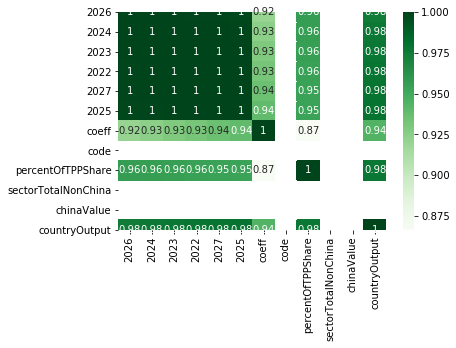

In [36]:
corrMatNoRedis = eiNoRedis.corr()
sb.heatmap(corrMatNoRedis, cmap="Greens", annot=True)

## Correlation Matrix for CPATPP With a China Crisis

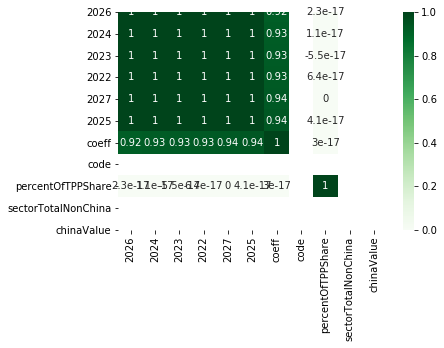

In [37]:
corrMatNoRedis = eiPostRedis.corr()
sb.heatmap(corrMatNoRedis, cmap="Greens", annot=True)

## Creating Winners in the Sub-sampled industry Case Study

The crisis in the China Strait would most likely produce a tighter correlation between economic growth rates, among CPATPP nations. 

As CPATPP nations take up the left-over share of Chinese exports, their growth rates grow more in sync, if they follow a goal of pursuing growth based on their proportional share of industry, 2021. 

Instead of driving these nations farther apart and widening gaps in income, this experiment reveals that expanding their share of exports to the United States, that they grow more competitve with each other. Instead of creating laggards, due to expanded volumes, the change of volume causes them to grow in sync. 

## Opportunities-In-Crises

Though this represents only one study, it could be recreated, using different growth goals, and differnt rules for linear studies. For example, both the above studies does not include a down year, due to the emergency uptake of orders to the US. A reasonable growth model would include randomly induced-forecast weak years. The above two models assume the China crisis creates a meaningful surge in demand, to make up for missing supply chains. 

Given the movement within the Electronics industry to redistribute industrial capacity to India and Vietnam, from China, this would cause these production centers to expand. 

However, this linear correlation study is meant to augment the Bigger-Than study, above, where a range of potential growth could take place, in order to move production of every sector above its respective 0 value, and make up deficits created by China, currently. 

The author hopes that all nations involved see this model as a means to preclude warfare by any or all means. However, given the client's own interests for 1) assuaging a potential supply chain crisis, and 2) precluding the economic growth of a belligerent trade partner, the interests of the client must be answered. 

## Sources of Uncertainty in the Study

Creating rules to a game take longer than coding them. The author spent more time in front of a white board than at the computer, devising potentially fair simulation conditions. This is not the right way to do this; instead, the corect way to model what-if scenarios involving multi-layer data streams like this one, is to deliver the client a margin for which the problem may be solved. 

The role played by existing dominant players, for example Mexico in electronic manufacture, could be multiplied beyond what a smaller player could do. Conversely, according to the 2021 model, India was a small electronics industry player; this will change as the industry normalizes there, as it did in China, years 1980 to the present. 

It is not fair to assume that large players can out-accelerate small ones. However, simply asking any market participant to expand their output is a major, and highly contingent ask. It behooved the modelers to simply assume that countervailing variables contribute to the expansion. We in the US experienced whole manufacturing plants boxed up and moved to China, as Bitcoin miners and silicon wafer manufacturers have done recently, and plan to do more. 

Displacing an industry is a fact of globalization, as well as training new labor. Other variables could explain the rise of manufacturing better than this one. However, the tools for modeling disruption in global supply chains can adopt this code base, and supplant algorithms in place of mine. 
